# AutoML Image Classification: Added Noise (Fashion)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [5]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [1]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*3
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=48)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=True)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

NameError: name 'ABC' is not defined

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": H2OAutoMLModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": H2OAutoMLModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
import torch
print(torch.cuda.get_device_name(0))

train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

121.75 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

120.81 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpjzrbxtyc

  JVM stdout: /wrk/users/thalvari/tmpjzrbxtyc/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpjzrbxtyc/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,10 days
H2O cluster name:,#336177444
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b963 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.977

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpgxlki0cs

  JVM stdout: /wrk/users/thalvari/tmpgxlki0cs/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpgxlki0cs/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,10 days
H2O cluster name:,#897189293
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9e17 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.981

 17%|█▋        | 1/6 [11:37:09<58:05:49, 41829.98s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.911

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.7

124.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(RandomForestClassifier(DecisionTreeClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=7, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=15, n_estimators=100, subsample=0.6500000000000001), criterion=entropy, max_depth=7, min_samples_leaf=17, min_samples_split=9), bootstrap=False, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=16, min_samples_split=11, n_estimators=100), n_neighbors=6, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.949

121.25 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.778

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphkcgp9qy

  JVM stdout: /wrk/users/thalvari/tmphkcgp9qy/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphkcgp9qy/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#424740945
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bca6 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.949

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp6pheaqx1

  JVM stdout: /wrk/users/thalvari/tmp6pheaqx1/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp6pheaqx1/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#16920613
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a0ad closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.638

 33%|███▎      | 2/6 [23:34:29<46:52:51, 42192.88s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.895

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.455

124.53 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(ZeroCount(RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.2, min_samples_leaf=3, min_samples_split=6, n_estimators=100))), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.938

121.82 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.506

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp0eq9u44m

  JVM stdout: /wrk/users/thalvari/tmp0eq9u44m/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp0eq9u44m/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#923355577
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b1d0 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.907

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp6x1546qv

  JVM stdout: /wrk/users/thalvari/tmp6x1546qv/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp6x1546qv/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#141772760
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bc47 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.389

 50%|█████     | 3/6 [35:24:56<35:16:09, 42323.20s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.821

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.342

124.19 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=7, max_features=0.5, min_samples_leaf=10, min_samples_split=9, n_estimators=100, subsample=0.5), n_neighbors=5, p=1, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.895

120.18 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.405

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphsvl_9he

  JVM stdout: /wrk/users/thalvari/tmphsvl_9he/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphsvl_9he/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#888182019
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bc32 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.907

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmprmm51_23

  JVM stdout: /wrk/users/thalvari/tmprmm51_23/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmprmm51_23/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#113725666
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b78b closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.304

 67%|██████▋   | 4/6 [47:10:03<23:30:36, 42318.28s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.79

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.296

122.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(XGBClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=7, max_features=0.7000000000000001, min_samples_leaf=5, min_samples_split=16, n_estimators=100, subsample=0.05), learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.05), n_neighbors=6, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.837

121.57 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.335

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpsj0e5aj2

  JVM stdout: /wrk/users/thalvari/tmpsj0e5aj2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpsj0e5aj2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#372846814
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bf54 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.856

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1j2v19iq

  JVM stdout: /wrk/users/thalvari/tmp1j2v19iq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1j2v19iq/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#1022420898
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ba15 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.288

 83%|████████▎ | 5/6 [58:50:18<11:43:47, 42227.22s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.755

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.292

128.78 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(KNeighborsClassifier(ZeroCount(ZeroCount(RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=18, n_estimators=100))), n_neighbors=25, p=2, weights=distance)), n_neighbors=2, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.825

120.88 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.37

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpo3lawri3

  JVM stdout: /wrk/users/thalvari/tmpo3lawri3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpo3lawri3/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,13 days
H2O cluster name:,#132774855
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ab02 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.872

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvry5u50p

  JVM stdout: /wrk/users/thalvari/tmpvry5u50p/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvry5u50p/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,13 days
H2O cluster name:,#451032736
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b702 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.272

100%|██████████| 6/6 [70:43:22<00:00, 42394.32s/it]   

100%|██████████| 6/6 [70:43:22<00:00, 42433.78s/it]

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.216,0.002,7211.91
36,0.911,0.994,0.241,0.001,7290.28
72,0.895,0.99,0.29,0.001,7211.25
108,0.821,0.986,0.254,0.002,7218.75
144,0.79,0.977,0.206,0.001,7258.61
180,0.755,0.975,0.252,0.001,7204.29


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, 

'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.216,0.002,7248.04
36,0.7,0.999,0.241,0.001,7226.17
72,0.455,0.999,0.29,0.001,7206.2
108,0.342,0.999,0.254,0.002,7206.96
144,0.296,0.999,0.206,0.001,7233.37
180,0.292,0.999,0.252,0.001,7206.75


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=Tru

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.977,1,0.216,0.002,6395.08
36,0.949,1,0.241,0.001,7371.35
72,0.907,1,0.29,0.001,7017.3
108,0.907,1,0.254,0.002,6799.36
144,0.856,1,0.206,0.001,6494.5
180,0.872,1,0.252,0.001,6966.97


'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.216,0.002,6387.85
36,0.638,1,0.241,0.001,6384.8
72,0.389,1,0.29,0.001,6388.68
108,0.304,1,0.254,0.002,6390.61
144,0.288,1,0.206,0.001,6384.26
180,0.272,1,0.252,0.001,6385.68


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6
0,StackedEnsemble_BestOfFamily_AutoML_20191118_035800,DeepLearning_grid_1_AutoML_20191118_035800_model_33,GBM_grid_1_AutoML_20191118_035800_model_145,XGBoost_grid_1_AutoML_20191118_035800_model_13,DRF_1_AutoML_20191118_035800,XRT_1_AutoML_20191118_035800,GLM_grid_1_AutoML_20191118_035800_model_1
36,StackedEnsemble_BestOfFamily_AutoML_20191118_155524,DeepLearning_grid_1_AutoML_20191118_155524_model_2,GBM_grid_1_AutoML_20191118_155524_model_145,XGBoost_grid_1_AutoML_20191118_155524_model_13,DRF_1_AutoML_20191118_155524,XRT_1_AutoML_20191118_155524,GLM_grid_1_AutoML_20191118_155524_model_1
72,DeepLearning_grid_1_AutoML_20191119_034547_model_32,nan,nan,nan,nan,nan,nan
108,DeepLearning_grid_1_AutoML_20191119_153053_model_42,nan,nan,nan,nan,nan,nan
144,StackedEnsemble_BestOfFamily_AutoML_20191120_031112,DeepLearning_grid_1_AutoML_20191120_031112_model_2,GBM_grid_1_AutoML_20191120_031112_model_145,XGBoost_grid_1_AutoML_20191120_031112_model_13,DRF_1_AutoML_20191120_031112,XRT_1_AutoML_20191120_031112,GLM_grid_1_AutoML_20191120_031112_model_1
180,StackedEnsemble_BestOfFamily_AutoML_20191120_150416,DeepLearning_grid_1_AutoML_20191120_150416_model_6,GBM_grid_1_AutoML_20191120_150416_model_145,XGBoost_grid_1_AutoML_20191120_150416_model_13,DRF_1_AutoML_20191120_150416,XRT_1_AutoML_20191120_150416,GLM_grid_1_AutoML_20191120_150416_model_1


'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.216,0.002,7321.4
36,0.949,1,0.241,0.001,7476.24
72,0.938,1,0.29,0.001,7477.87
108,0.895,1,0.254,0.002,7463.48
144,0.837,1,0.206,0.001,7333.11
180,0.825,1,0.252,0.001,7751.11


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan
36,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.01, loss='deviance', max_depth=7, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=7, min_samples_split=15, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.6500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=17, min_samples_split=9, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.15000000000000002, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=16, min_samples_split=11, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=2, weights='distance')",nan,nan
72,"StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.2, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=3, min_samples_split=6, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))",ZeroCount(),MaxAbsScaler(copy=True),"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan,nan
108,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=7, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.5, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=5, p=1, weights='distance')",nan,nan,nan,nan
144,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='fri

'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.216,0.002,7264.38
36,0.778,1,0.241,0.001,7290.55
72,0.506,1,0.29,0.001,7325.4
108,0.405,1,0.254,0.002,7226.99
144,0.335,1,0.206,0.001,7309.98
180,0.37,1,0.252,0.001,7269.21


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
36,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
72,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
108,"PCA(copy=True, iterated_power=6, n_components=None, random_state=4

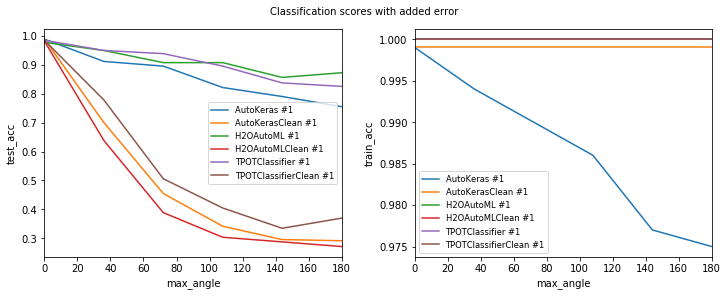

In [11]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)